In [2]:
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
import wget
import os
import time
import matplotlib.pyplot as plt
import tensorflow as tf
##______
import torch.nn as nn
from tqdm import tqdm
from torch.nn import functional as F
##______
import requests
from io import BytesIO
from PIL import Image
#__________
import urllib.request


In [3]:
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image


In [28]:
url ="https://file.mk.co.kr/meet/neds/2021/03/image_readtop_2021_245784_16157915294573638.jpg"
wget.download(url)

100% [..............................................................................] 92893 / 92893

'image_readtop_2021_245784_16157915294573638 (1).jpg'

In [29]:
pip install people_segmentation

Note: you may need to restart the kernel to use updated packages.


In [30]:
from people_segmentation.pre_trained_models import create_model

In [31]:
model = create_model("Unet_2020-07-20")

In [32]:
model.eval();

In [33]:
def resize_crop(image):
    h, w, c = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w, :]
    return image

def resize_mincrop(image):
    h, w, c = np.shape(image)
    if min(h, w) < 720:
        if h < w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w, :]
    return image

def resize_mask(image):
    h, w = np.shape(image)
    if min(h, w) > 720:
        if h > w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w]
    return image

def resize_minmask(image):
    h, w = np.shape(image)
    if min(h, w) < 720:
        if h < w:
            h, w = int(720*h/w), 720
        else:
            h, w = 720, int(720*w/h)
    image = cv2.resize(image, (w, h), interpolation=cv2.INTER_AREA)
    h, w = (h//8)*8, (w//8)*8
    image = image[:h, :w]
    return image



In [37]:
def resize_select(image):
    h, w, c = np.shape(image)
    if min(h, w, c) > 720:
        return resize_crop(image)
    else:  
        return resize_mincrop(image)

In [38]:
image1 = load_rgb('image_readtop_2021_245784_16157915294573638 (1).jpg')

In [39]:
print(np.shape(image1))

(501, 731, 3)


(501, 731, 3)


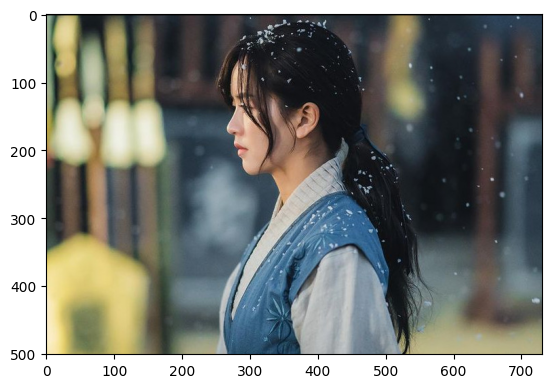

In [57]:
image = resize_select(image1)
print(image1.shape)
plt.imshow(image1)

###(720, 960, 3)

(488, 720, 3)


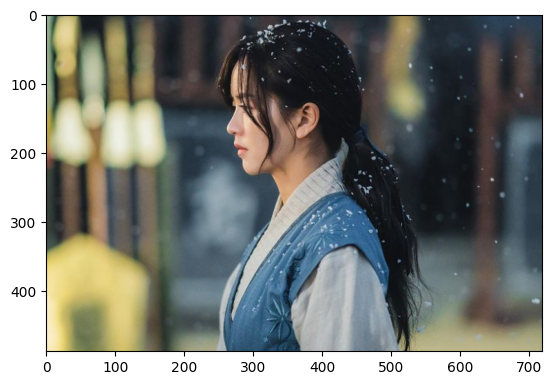

In [58]:
cv2.imwrite('pop.jpg', image)
plt.imshow(image)
print(image.shape)
##(720, 952, 3)
 

In [44]:
transform = albu.Compose([albu.Normalize(p=1)], p=1)

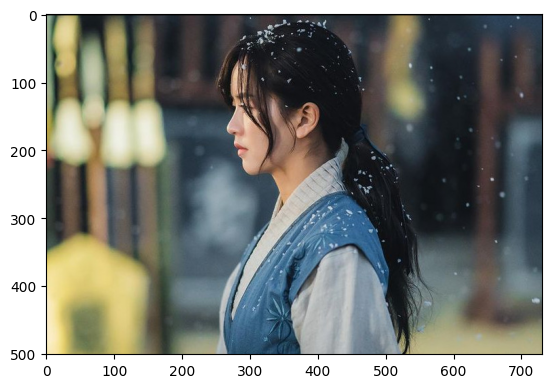

In [45]:
cv2.imwrite('pop1.jpg', image1)###사이즈 변경하지

imshow(image1)

(501, 731, 3)


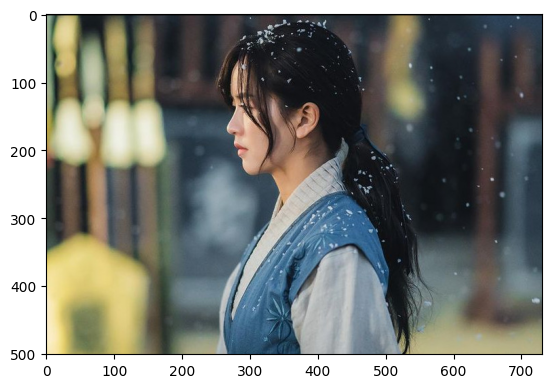

In [46]:
imshow(image1)
print(image1.shape)

In [47]:
padded_image, pads = pad(image1, factor=32, border=cv2.BORDER_CONSTANT)

In [48]:
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

In [49]:
with torch.no_grad():
  prediction = model(x)[0][0]

In [50]:
mask = (prediction > 0).cpu().numpy().astype(np.uint8)

In [51]:
mask = unpad(mask, pads)


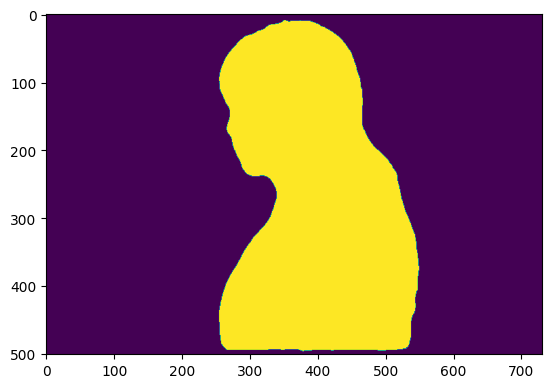

In [52]:
imshow(mask)

In [53]:
def resize_select_mask(mask):
    h, w = np.shape(mask)
    np.shape(mask)
    if h < 720:
        return resize_minmask(mask)
    else: 
         return resize_mask(mask)

(488, 720)


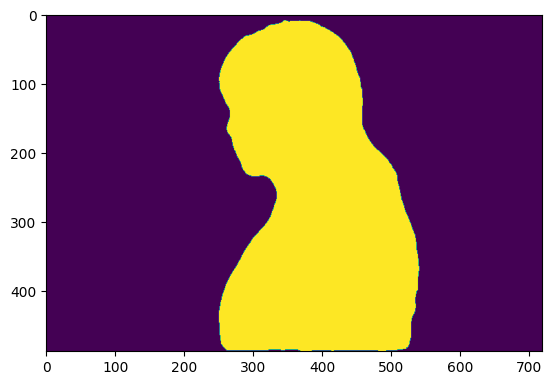

In [54]:
mask10 = resize_minmask(mask)
plt.imshow(mask10)
print(mask10.shape)

In [55]:

###_____________________________________________________ ____________________________________________________
class ResBlock(nn.Module):
    def __init__(self, num_channel):
        super(ResBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(num_channel, num_channel, 3, 1, 1),
            nn.BatchNorm2d(num_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channel, num_channel, 3, 1, 1),
            nn.BatchNorm2d(num_channel))
        self.activation = nn.ReLU(inplace=True)

    def forward(self, inputs):
        output = self.conv_layer(inputs)
        output = self.activation(output + inputs)
        return output


class DownBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(DownBlock, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, 2, 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True))


    def forward(self, inputs):
        output = self.conv_layer(inputs)
        return output


class UpBlock(nn.Module):
    def __init__(self, in_channel, out_channel, is_last=False):
        super(UpBlock, self).__init__()
        self.is_last = is_last
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, 1, 1),
            nn.BatchNorm2d(in_channel),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channel, out_channel, 3, 1, 1))
        self.act = nn.Sequential(
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True))
        self.last_act = nn.Tanh()


    def forward(self, inputs):
        output = self.conv_layer(inputs)
        if self.is_last:
            output = self.last_act(output)
        else:
            output = self.act(output)
        return output



class SimpleGenerator(nn.Module):
    def __init__(self, num_channel=32, num_blocks=4):
        super(SimpleGenerator, self).__init__()
        self.down1 = DownBlock(3, num_channel)
        self.down2 = DownBlock(num_channel, num_channel*2)
        self.down3 = DownBlock(num_channel*2, num_channel*3)
        self.down4 = DownBlock(num_channel*3, num_channel*4)
        res_blocks = [ResBlock(num_channel*4)]*num_blocks
        self.res_blocks = nn.Sequential(*res_blocks)
        self.up1 = UpBlock(num_channel*4, num_channel*3)
        self.up2 = UpBlock(num_channel*3, num_channel*2)
        self.up3 = UpBlock(num_channel*2, num_channel)
        self.up4 = UpBlock(num_channel, 3, is_last=True)

    def forward(self, inputs):
        down1 = self.down1(inputs)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down4 = self.res_blocks(down4)
        up1 = self.up1(down4)
        up2 = self.up2(up1+down3)
        up3 = self.up3(up2+down2)
        up4 = self.up4(up3+down1)
        return up4
    


if __name__ == '__main__':
    weight = torch.load('C:/Users/Admin/Desktop/NewCartoon_filter/FacialCartoonization/weight.pth', map_location='cpu')
    model = SimpleGenerator()
    model.load_state_dict(weight)
    #torch.save(model.state_dict(), 'weight.pth')
    model.eval()
    ##여기까지는 모델입니다.  
    raw_image = cv2.imread('pop.jpg')
    
    image = raw_image/127.5 - 1
    image = image.transpose(2, 0, 1)
    image = torch.tensor(image).unsqueeze(0)
    output = model(image.float())
    output = output.squeeze(0).detach().numpy()
    output = output.transpose(1, 2, 0)
    output = (output + 1) * 127.5
    output = np.clip(output, 0, 255).astype(np.uint8)
    cv2.imwrite('combined.jpg', output)
##______________________________________________________________________________________________________________

    img = np.array(Image.open('combined.jpg'))

    fg_h, fg_w, _ = img.shape

    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    axes[0].imshow(output)
    axes[1].imshow(img)

RuntimeError: The size of tensor a (92) must match the size of tensor b (91) at non-singleton dimension 3

(720, 400, 3)


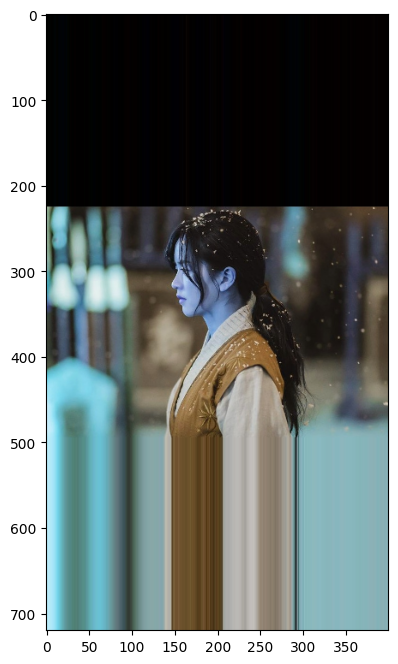

In [56]:
background = np.array(Image.open('pop.jpg'))

bg_h, bg_w, _ = background.shape

# fit to fg width
background = cv2.resize(background, dsize=(fg_w, int(fg_w * bg_h / bg_w)))

bg_h, bg_w, _ = background.shape

margin = (bg_h - fg_h) // 2

if margin > 0:
    background = background[margin:-margin, :, :]
else:
    background = cv2.copyMakeBorder(background, top=abs(margin), bottom=abs(margin), left=0, right=0, borderType=cv2.BORDER_REPLICATE)

# final resize
background = cv2.resize(background, dsize=(fg_w, fg_h))

plt.figure(figsize=(12, 8))
plt.imshow(background)


print(background.shape)

In [ ]:
_, alpha = cv2.threshold(mask10, 0, 255, cv2.THRESH_BINARY)

alpha = cv2.GaussianBlur(alpha, (7, 7), 0).astype(float)

alpha = alpha / 255. # (height, width)
alpha = np.repeat(np.expand_dims(alpha, axis=2), 3, axis=2) # (height, width, 3)

foreground = cv2.multiply(alpha, img.astype(float))
background = cv2.multiply(1. - alpha, background.astype(float))  

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(mask10)
axes[1].imshow(foreground.astype(np.uint8))
axes[2].imshow(background.astype(np.uint8))

In [ ]:
result = cv2.add(foreground, background).astype(np.uint8)

plt.figure(figsize=(12, 12))
fix_img = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(fix_img)

In [ ]:
plt.imshow(fix_img)